In [ ]:
import torch
from torch import nn
from torch import optim

In [ ]:
def agent_1(x):
  return 0.5 * x**2
def agent_2(x):
  return x**2
def agent_3(x):
  return 1.5 * x**2


class LagrangeLoss(nn.Module):
  def __init__(self, agents, mus):
    super(LagrangeLoss, self).__init__()
    self.mus = mus
    self.agents = agents
  
  def apply_cost_function(self, x):
    result = torch.zeros(x.shape)
    for i, agent in enumerate(self.agents):
      result = result + agent(x) * torch.tensor([1.0 if j==i else 0.0 for j in range(x.shape[0])])
    return result

  def calc_IR(self, x, w, z):
    result = w - self.apply_cost_function(x) - z**2
    return result
  
  def calc_IC_agent(self, x, w, lambdas, agent, i, z):
    mask = torch.tensor([1.0 if j==i else 0.0 for j in range(x.shape[0])])
    result = torch.sum((w - agent(x)) * mask) 
    result = torch.sum((result -  (w - agent(x)) -  z**2) * lambdas )
    return result
  
  '''def calc_IC_agent(self, x, w, lambdas, agent, i, z):
    mask = torch.tensor([1.0 if j==i else 0.0 for j in range(x.shape[0])])
    result = torch.sum((w - agent(x)) * mask) * lambdas
    result = torch.sum(result - lambdas * (w - agent(x)) - lambdas * z**2 )
    return result'''

  def calc_IC(self, x, w, lambdas, z):
    result = torch.tensor([0.0])
    for i, agent in enumerate(self.agents):
      result = result + self.calc_IC_agent(x, w, lambdas[i], agent, i, z[i])
    return result

  def forward(self, x, w, lambdas, z, IR_lambdas, IR_z):
    revenue = torch.sum(self.mus * (x - w))
      
    IR_const = torch.sum(lambdas[0] * self.calc_IR(x, w, z[0]))
    IC_const = self.calc_IC(x, w, IR_lambdas, IR_z)
    pos_x_const = torch.sum(lambdas[1] * (x - z[1]**2))
    pos_w_const = torch.sum(lambdas[2] * (w - z[2]**2))
    return - revenue + IR_const + IC_const + pos_x_const + pos_w_const 

In [ ]:
class Model(nn.Module):  
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.tensor([1e-25]*3))
        self.w = nn.Parameter(torch.tensor([1e-25]*3)) 
        self.lambdas = nn.Parameter(torch.tensor([[1e-25]*3 for i in range(3)]))
        self.z = nn.Parameter(torch.tensor([[1e-25]*3 for i in range(3)]))
        self.IR_lambdas = nn.Parameter(torch.tensor([[1e-25]*3 for i in range(3)]))       
        self.IR_z = nn.Parameter(torch.tensor([[1e-25]*3 for i in range(3)]))  

    def forward(self):
        return self.x, self.w, self.lambdas, self.z, self.IR_lambdas, self.IR_z

In [ ]:
model = Model()
loss_fn = LagrangeLoss([agent_1, agent_2, agent_3], torch.tensor([3/8, 1/8, 1/2]))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
w_history, x_history, loss_history = [], [], []

In [ ]:
for i in range(150000):
  if i>=50000 and i <=100000:
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
  elif i > 100000:
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
  optimizer.zero_grad()
  x, w, lambdas, z, IR_lambdas, IR_z = model()
  loss = loss_fn(x, w, lambdas, z, IR_lambdas, IR_z)
  loss_history.append(loss.item())
  x_history.append([el.item() for el in model.x.detach().numpy()])
  w_history.append([el.item() for el in model.w.detach().numpy()])
  loss.backward()

  model.lambdas.grad = - model.lambdas.grad
  model.IR_lambdas.grad = - model.IR_lambdas.grad
  optimizer.step()

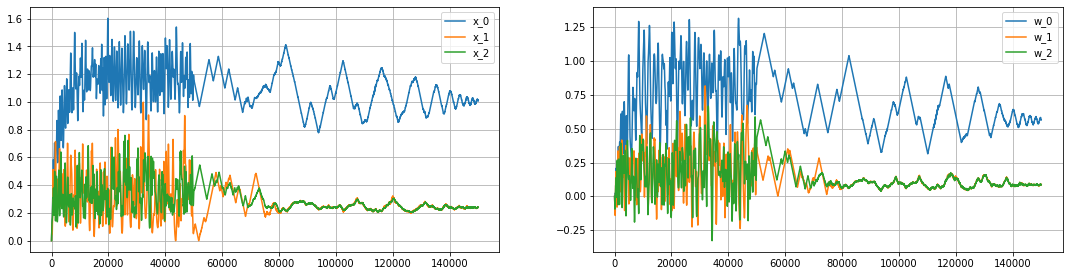

In [ ]:
from matplotlib import pyplot as plt
X = pd.DataFrame(x_history)
W = pd.DataFrame(w_history)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18.5, 4.5)
X.rename(columns={0:'x_0', 1:'x_1', 2:'x_2'}).plot(ax=ax[0], grid=True) 
W.rename(columns={0:'w_0', 1:'w_1', 2:'w_2'}).plot(ax=ax[1], grid=True).plot(ax=ax[1], grid=True)
plt.show()

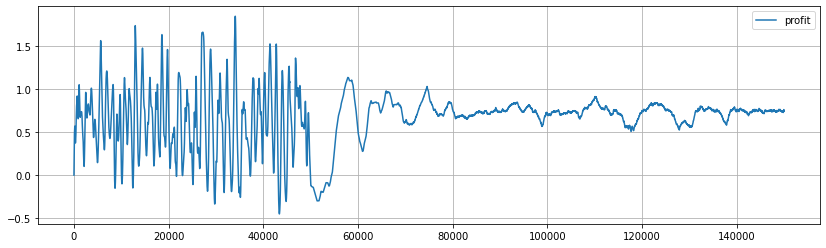

In [ ]:
import numpy as np
pd.DataFrame({'profit':np.sum(x_history, axis=1) - np.sum(w_history, axis=1)}).plot(grid=True, figsize=(14, 4))
plt.show()

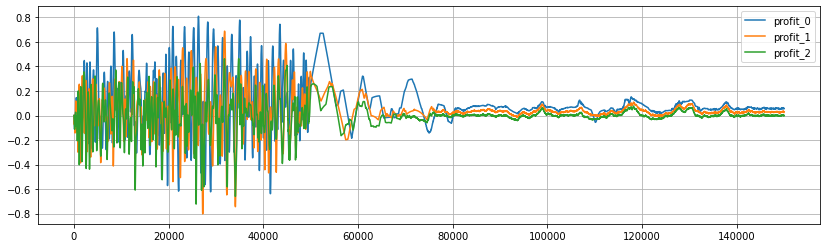

In [ ]:
(pd.DataFrame([i for i in X.apply(lambda x: [-agent_1(x.loc[0]), -agent_2(x.loc[1]), -agent_3(x.loc[2])], axis=1).values]) + W
 ).rename(columns={0:'profit_0', 1:'profit_1', 2:'profit_2'}).plot(grid=True, figsize=(14, 4))
plt.show()

In [ ]:
print('Доход агентов')
(pd.DataFrame([i for i in X.apply(lambda x: [-agent_1(x.loc[0]), -agent_2(x.loc[1]), -agent_3(x.loc[2])], axis=1).values]) + W).tail(1)

Доход агентов


,0,1,2
149999,0.057546,0.031359,0.000447


In [ ]:
print('Прибыль принципала')
pd.Series(np.sum(x_history, axis=1) - np.sum(w_history, axis=1)).tail(1)

Прибыль принципала


149999    0.745559
dtype: float64

In [ ]:
model.x, model.w

(Parameter containing:
 tensor([1.0066, 0.2383, 0.2391], requires_grad=True), Parameter containing:
 tensor([0.5642, 0.0883, 0.0864], requires_grad=True))